In [1]:
from helikite import Cleaner, instruments
import os
import datetime

cleaner = Cleaner(
    instruments=[
        instruments.flight_computer_v2,
        instruments.smart_tether,
        instruments.pops,
        instruments.msems_readings,
        instruments.msems_inverted,
        instruments.msems_scan,
        # instruments.stap,
    ], 
    reference_instrument=instruments.flight_computer_v2,
    input_folder=os.path.join(os.getcwd(), "rawdata"),
    flight_date=datetime.date(2025,2,12),
    time_takeoff=datetime.datetime(2025,2,12,7,59,35),
    time_landing=datetime.datetime(2025,2,12,10,17,9),
    time_offset=datetime.time(0),
)

cleaner.set_time_as_index()
cleaner.data_corrections()
cleaner.set_pressure_column()
# cleaner.correct_time_and_pressure(max_lag=180)
cleaner.remove_duplicates()
cleaner.merge_instruments()
cleaner.export_data()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\calmer\\Documents\\VAERTICAL\\Helikite\\Github\\helikite-data-processing\\notebooks\\rawdata'

In [2]:
from helikite.metadata.utils import load_parquet

df, metadata = load_parquet("level0_2025-02-12T07-55.parquet")

In [3]:
metadata

Flight None from 2025-02-12 07:59:35 to 2025-02-12 10:17:09

In [4]:
# To use individual fields, just use the object (.) notation, for example
print(metadata.flight_date)
print(metadata.landing_time)
metadata.takeoff_time


2025-02-12
2025-02-12 10:17:09


Timestamp('2025-02-12 07:59:35')

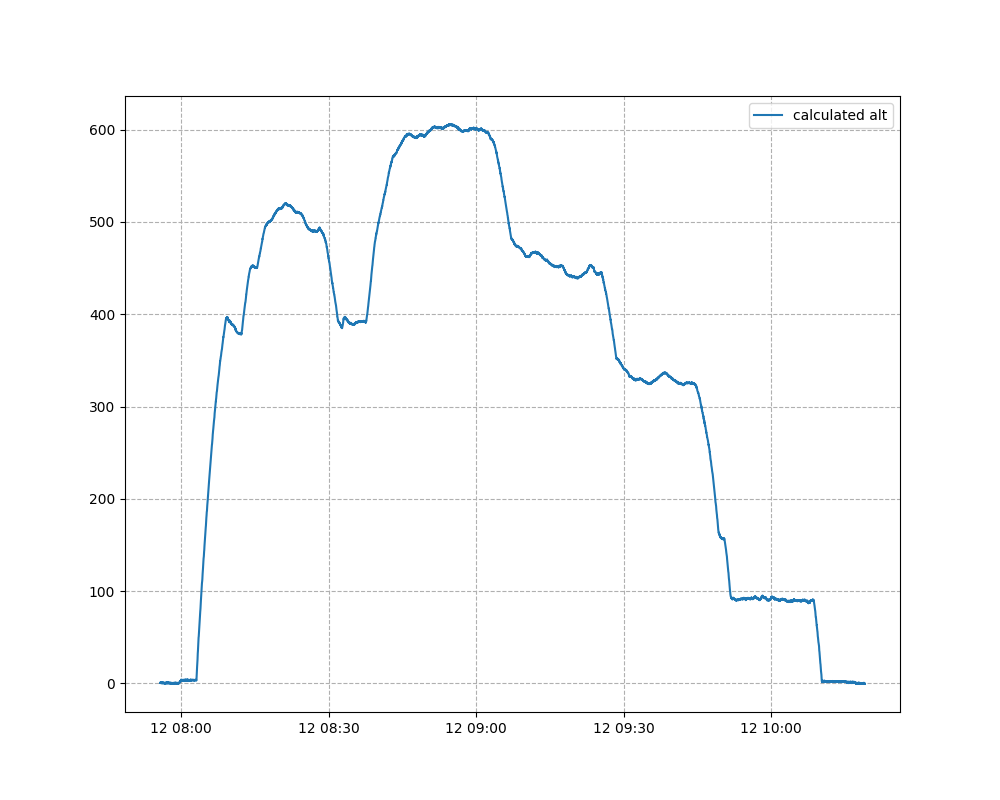

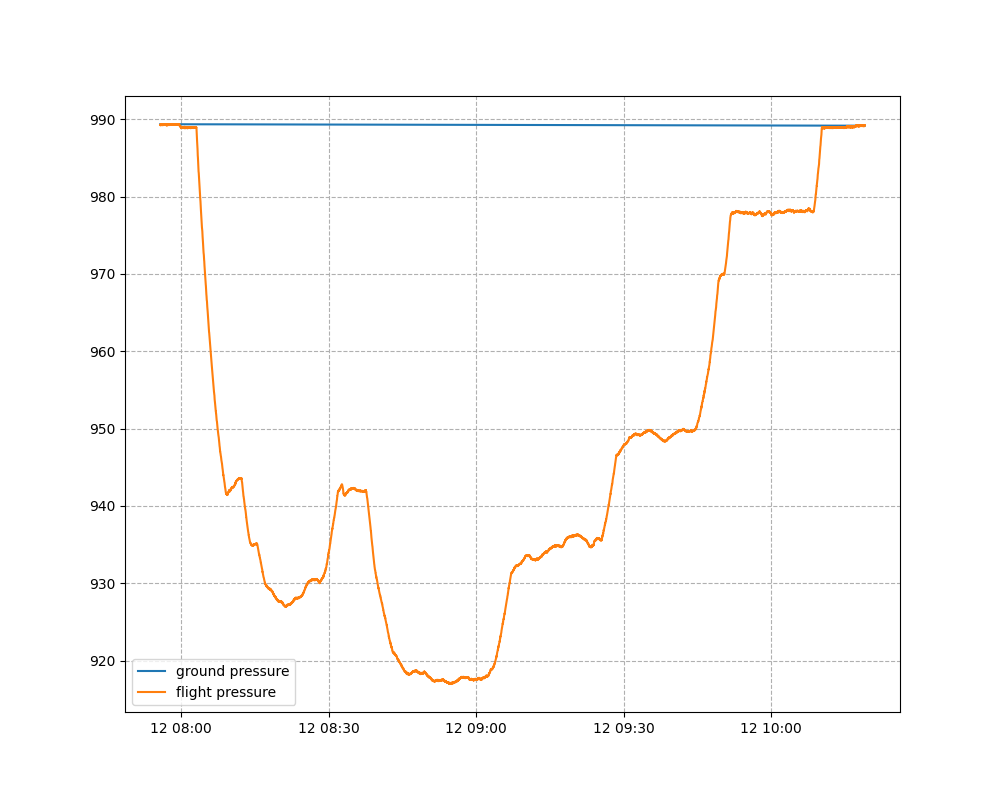

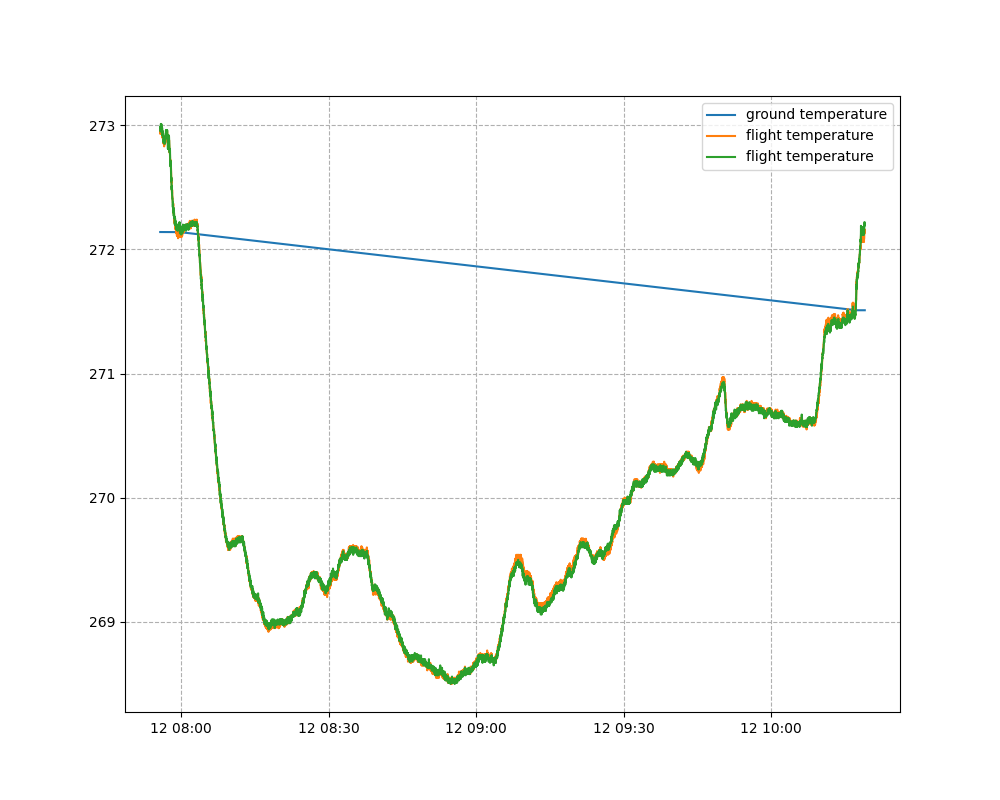

In [5]:
# # # Altitude calculation
from helikite.processing.post import altitude
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib ipympl
plt.close('all')

def calculate_ground(df, takeoff_time, landing_time):
    """
    Interpolates pressure and temperature between takeoff and landing times,
    filling NaN values before takeoff and after landing.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing flight data.
        takeoff_time (datetime): Timestamp of takeoff.
        landing_time (datetime): Timestamp of landing.
        
    Returns:
        pd.DataFrame: DataFrame with 'Pressure_ground' and 'Temperature_ground' columns.
    """
    # Ensure DateTime column exists
    df = df.copy()  # Avoid modifying the original DataFrame
    df['DateTime'] = df.index  

    # Extract takeoff and landing pressure & temperature (convert temp to Kelvin)
    Pground = [df.at[takeoff_time, 'flight_computer_BME_P'], 
               df.at[landing_time, 'flight_computer_BME_P']]
    Tground = [df.at[takeoff_time, 'flight_computer_Out1_T'] + 273.15,  
               df.at[landing_time, 'flight_computer_Out1_T'] + 273.15]  

    # Create DataFrame for interpolation
    interp_df = pd.DataFrame({'Pressure': Pground, 'Temperature': Tground}, index=[takeoff_time, landing_time])

    # Create a new index for interpolation
    Timeinterp = df.loc[takeoff_time:landing_time, 'DateTime']

    # Reindex with full time range
    interp_df = interp_df.reindex(interp_df.index.union(Timeinterp))

    # Perform time-based interpolation
    interp_df = interp_df.interpolate(method='time')

    # Map interpolated values back to the original DataFrame
    df['Pressure_ground'] = df['DateTime'].map(interp_df['Pressure'])
    df['Temperature_ground'] = df['DateTime'].map(interp_df['Temperature'])

    # Ensure first and last values are correctly set
    df.at[df.index[0], 'Pressure_ground'] = Pground[0]
    df.at[df.index[-1], 'Pressure_ground'] = Pground[1]
    df.at[df.index[0], 'Temperature_ground'] = Tground[0]
    df.at[df.index[-1], 'Temperature_ground'] = Tground[1]

    # Fill NaN values before takeoff and after landing
    df[['Pressure_ground', 'Temperature_ground']] = df[['Pressure_ground', 'Temperature_ground']].ffill().bfill()

    return df[['Pressure_ground', 'Temperature_ground']]

############################################################################################
# # # linear interpolation of pressure and temparature to calculate the flight altitude
df[['Pressure_ground','Temperature_ground']]=calculate_ground(df,metadata.takeoff_time,metadata.landing_time)

# calculation of the flight altitude 
df['Altitude']=altitude.EstimateAltitude(df['Pressure_ground'], df['flight_computer_BME_P'], df['Temperature_ground'])
# print(df['Altitude'])

fig, (ax) = plt.subplots(1,1, figsize=(10,8))
ax.plot(df.index,df['Altitude'],label='calculated alt')
ax.grid(ls='--')
ax.legend()

fig, (ax) = plt.subplots(1,1, figsize=(10,8))
# ax.plot(df.index,df['Altitude'],label='calculated alt')
ax.plot(df.index,df['Pressure_ground'],label='ground pressure')
ax.plot(df.index,df['flight_computer_BME_P'],label='flight pressure')
ax.grid(ls='--')
ax.legend()

fig, (ax) = plt.subplots(1,1, figsize=(10,8))
# ax.plot(df.index,df['Altitude'],label='calculated alt')
ax.plot(df.index,df['Temperature_ground'],label='ground temperature')
# ax.plot(df.index,df['flight_computer_BME_T']+273.15,label='flight temperature') # box temperauture
ax.plot(df.index,df['flight_computer_Out1_T']+273.15,label='flight temperature')
ax.plot(df.index,df['flight_computer_Out2_T']+273.15,label='flight temperature')
ax.grid(ls='--')
ax.legend()

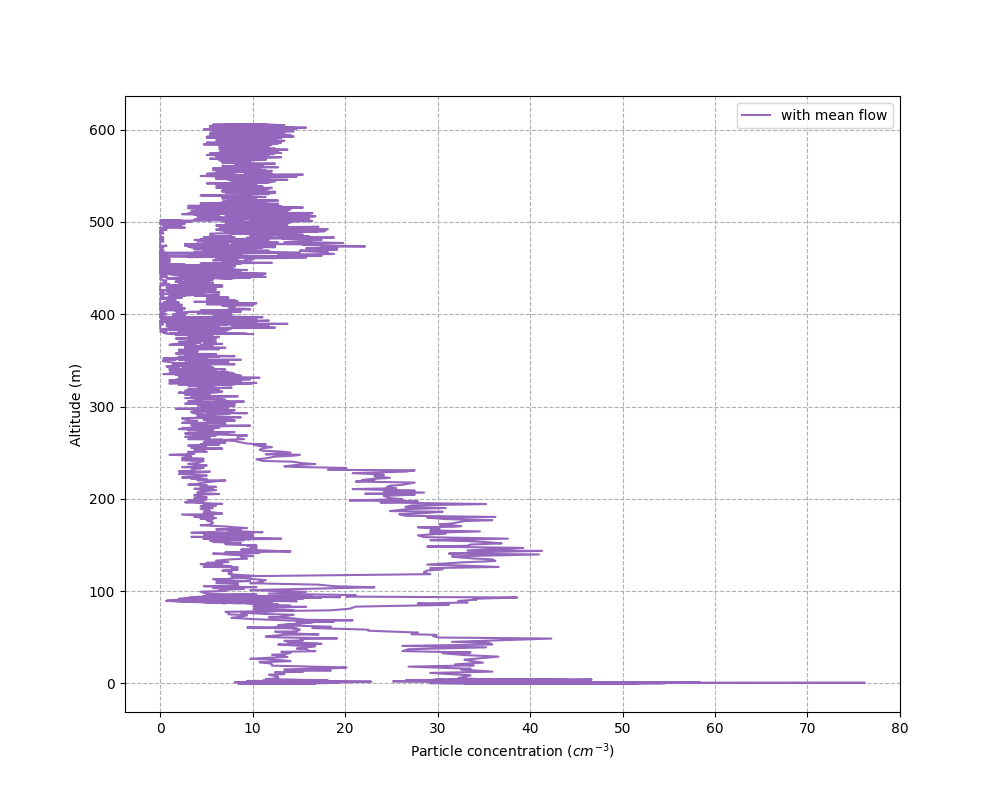

In [10]:
# # # POPS 

# # # calculate the total concentration and dNdlogdP for each bin

# # from Pohorsky et al., 2024
# # it appeared that particles with diameters
# between 142 and 186 (bins 1 to 3) are wrongly detected by the POPS as total particle concentration increases. This phenomenon
# can be explained by electronic noise from the detector, where fringes on the edge of the Gaussian signal are perceived as
# smaller particles by the software. It was therefore decided to only consider data for particles larger than 186 nm as the error
# 270 induced by the first three bins is too high.

pops_data= [col for col in df if col.startswith('pops_')]
df_pops = df[pops_data].copy()

# Remove duplicate column names before processing
df_pops = df_pops.loc[:, ~df_pops.columns.duplicated()].copy()

# POPS data calculate dNdlogDp
# Read the steps CSV file
filenotePOPS=os.path.join(os.getcwd(), os.pardir, "helikite", "tests", "resources", "campaigns", "20250212","POPS_dNdlogDp.txt")
dp_notes = pd.read_csv(filenotePOPS, sep="\t", skiprows=[0])

# Adjust dN_pops and calculate dNdlogDp
popsflow_mean = df_pops['pops_POPS_Flow'].mean()#2.9866
dN_pops = df_pops.filter(like='pops_b') / popsflow_mean
df_pops.loc[:,'pops_total_conc'] = dN_pops.loc[:, 'pops_b3':'pops_b15'].sum(axis=1)
dNdlogDp = dN_pops.loc[:, 'pops_b3':'pops_b15'].div(dp_notes['dlogdp'].iloc[3:].values, axis=1).add_suffix('_dlogDp')

# Add dNdlogDp columns to df
df_pops = pd.concat([df_pops, dNdlogDp], axis=1)

# Insert pops into df at the right position
if pops_data: 
    # Find the index of the last "pops_" column
    last_pops_index = df.columns.get_loc(pops_data[-1]) + 1  # Insert after this column
else:
    # If no such column exists, append to the end
    last_pops_index = len(df.columns)

df = pd.concat([df.iloc[:, :last_pops_index], df_pops, df.iloc[:, last_pops_index:]], axis=1)
df = df.loc[:, ~df.columns.duplicated()]

fig, (ax1) = plt.subplots(1,1, sharey = True, figsize=(10,8))
ax1.plot(df["pops_total_conc"],df['Altitude'],label='total conc',color='C4')
ax1.grid(ls='--')
ax1.set_xlabel('Particle concentration ($cm^{-3}$)')
ax1.set_ylabel("Altitude (m)")#"Pressure (mbar)")
ax1.legend()
# plt.savefig(figurefolder+'\\concentmean10s_altPOPS'+FLfigname+'.png')

In [ ]:
# print(df.columns.tolist())
msems_data= [col for col in df if col.startswith('msems_inverted_')]
print(df[msems_data].columns.tolist())

In [ ]:
# # # mSEMS
# # # calculation of DN from the mSEMS based on dNdlogDp

def calcN(df):
    #Calculate dlogDp
    start_column = 'msems_inverted_Bin_Dia1'
    end_column = 'msems_inverted_Bin_Dia60'
    bin_diams = df.loc[:,start_column:end_column]#iloc[:,4:63]#[:,4:44]
    # print(bin_diams.columns)
    bin_concs = df.loc[:,'msems_inverted_Bin_Conc1':'msems_inverted_Bin_Conc60']#iloc[:,64:123]#[:,44:84]
    # print(bin_concs.columns)
    CMD = df.loc[:,start_column:end_column]#.iloc[:,3:63]
    diff_df = CMD.diff(axis=1)
    delta = diff_df / 2
    upper_boundary = CMD + delta
    lower_boundary = CMD - delta
    log_lower = np.log10(lower_boundary)
    log_upper = np.log10(upper_boundary)
    dlogDp = log_upper - log_lower
    BD1_upper = lower_boundary["msems_inverted_Bin_Dia2"]
    BD1_lower = df["msems_inverted_Bin_Dia1"] - delta["msems_inverted_Bin_Dia2"]
    BD1 = np.log10(BD1_upper.replace(0, np.nan)) - np.log10(BD1_lower.replace(0, np.nan))
    dlogDp["msems_inverted_Bin_Dia1"] = BD1
    
     # Compute dN
    dlogDp_array = dlogDp.fillna(0).to_numpy()  # Convert to array & handle NaNs
    dN = bin_concs.mul(dlogDp_array, axis=1)

    # Sum without NaN issues
    dN["msems_inverted_totalconc"] = dN.sum(axis=1, skipna=True)
    # dN["msems_inverted_totalconc"]=dN["msems_inverted_totalconc"].replace(0, np.nan, inplace=True)
    dN.replace({"msems_inverted_totalconc": 0}, np.nan, inplace=True)
    
    return dN
##################################################################################################################   
# select only the mSEMS inverted columns
filter_msems= [col for col in df if col.startswith('msems_inverted_')]
msems_data = df[filter_msems]

# calculate DN for each bin and add the bins together for the total concentration
msems_dN= calcN(msems_data)

# rename the columns corresponding to dN
msems_dN=msems_dN.rename(columns=lambda col: col.replace('msems_inverted_','msems_inverted_dN_'))


# Insert msems_dN into df at the right position
if filter_msems: 
    # Find the index of the last "msems_inverted_" column
    last_msems_index = df.columns.get_loc(filter_msems[-1]) + 1  # Insert after this column
else:
    # If no such column exists, append to the end
    last_msems_index = len(df.columns)

df = pd.concat([df.iloc[:, :last_msems_index], msems_dN, df.iloc[:, last_msems_index:]], axis=1)

# print the list of column names if necessary to check
# print(df.columns.tolist())


# # # # plot mSEMS total concentration vs altitude to check the merging
fig, (ax) = plt.subplots(1,1, figsize=(10,8))
ax.plot(msems_dN['msems_inverted_dN_totalconc'], df['Altitude'],label = 'total conc',color='C0',marker ='.',linestyle='none')#, color="red" ,alpha=1, lw=1)
ax.grid(ls='--')
ax.set_ylabel('Altitude (m)', fontsize=22)
ax.set_xlabel("mSEMS dN (cm$^{-3}$)", fontsize=22)
ax.legend()
# fig.suptitle('Flight '+FLfigname, fontsize=22)

In [ ]:
# Otherwise, to make a dictionary from the metadata:
metadata_dict = metadata.model_dump()

# Then use it as a normal Python dictionary
metadata_dict['flight_date']

In [ ]:
# The dataframe is unpacked into the 'df' variable from that function above
df